<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Before you start

In order to complete the project you will need to create a developer account with OpenAI and store your API key as a secure environment variable. Instructions for these steps are outlined below.

### Create a developer account with OpenAI

1. Go to the [API signup page](https://platform.openai.com/signup). 

2. Create your account (you'll need to provide your email address and your phone number).

3. Go to the [API keys page](https://platform.openai.com/account/api-keys). 

4. Create a new secret key.

<img src="images/openai-new-secret-key.png" width="200">

5. **Take a copy of it**. (If you lose it, delete the key and create a new one.)

### Add a payment method

OpenAI sometimes provides free credits for the API, but this can vary depending on geography. You may need to add debit/credit card details. 

**This project should cost much less than 1 US cents with `gpt-4o-mini` (but if you rerun tasks, you will be charged every time).**

1. Go to the [Payment Methods page](https://platform.openai.com/account/billing/payment-methods).

2. Click Add payment method.

<img src="images/openai-add-payment-method.png" width="200">

3. Fill in your card details.

### Add an environmental variable with your OpenAI key

1. In the workbook, click on "Environment," in the top toolbar and select "Environment variables".

2. Click "Add" to add environment variables.

3. In the "Name" field, type "OPENAI_API_KEY". In the "Value" field, paste in your secret key.

<img src="images/datalab-env-var-details.png" width="500">

4. Click "Create", then you'll see the following pop-up window. Click "Connect," then wait 5-10 seconds for the kernel to restart, or restart it manually in the Run menu.

<img src="images/connect-integ.png" width="500">

## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [22]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI_API_KEY"]

## Install useful libraries

In [23]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

In [24]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [25]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [26]:
# Start coding here
# Use as many cells as you need.

In [27]:
# Filter the dataset to include only non-null reviews
valid_reviews = reviews[reviews['Review Text'].notnull()].copy()
texts = valid_reviews['Review Text'].tolist()


In [28]:

from openai import OpenAI
import numpy as np

client = OpenAI(api_key=openai_api_key)

def get_embeddings(texts):
    embeddings = []
    for i in range(0, len(texts), 100):  # Batch in 100s for efficiency
        response = client.embeddings.create(
            model="text-embedding-3-small",
            input=texts[i:i+100]
        )
        embeddings.extend([e.embedding for e in response.data])
    return embeddings

# Embed the texts
embeddings = get_embeddings(texts)


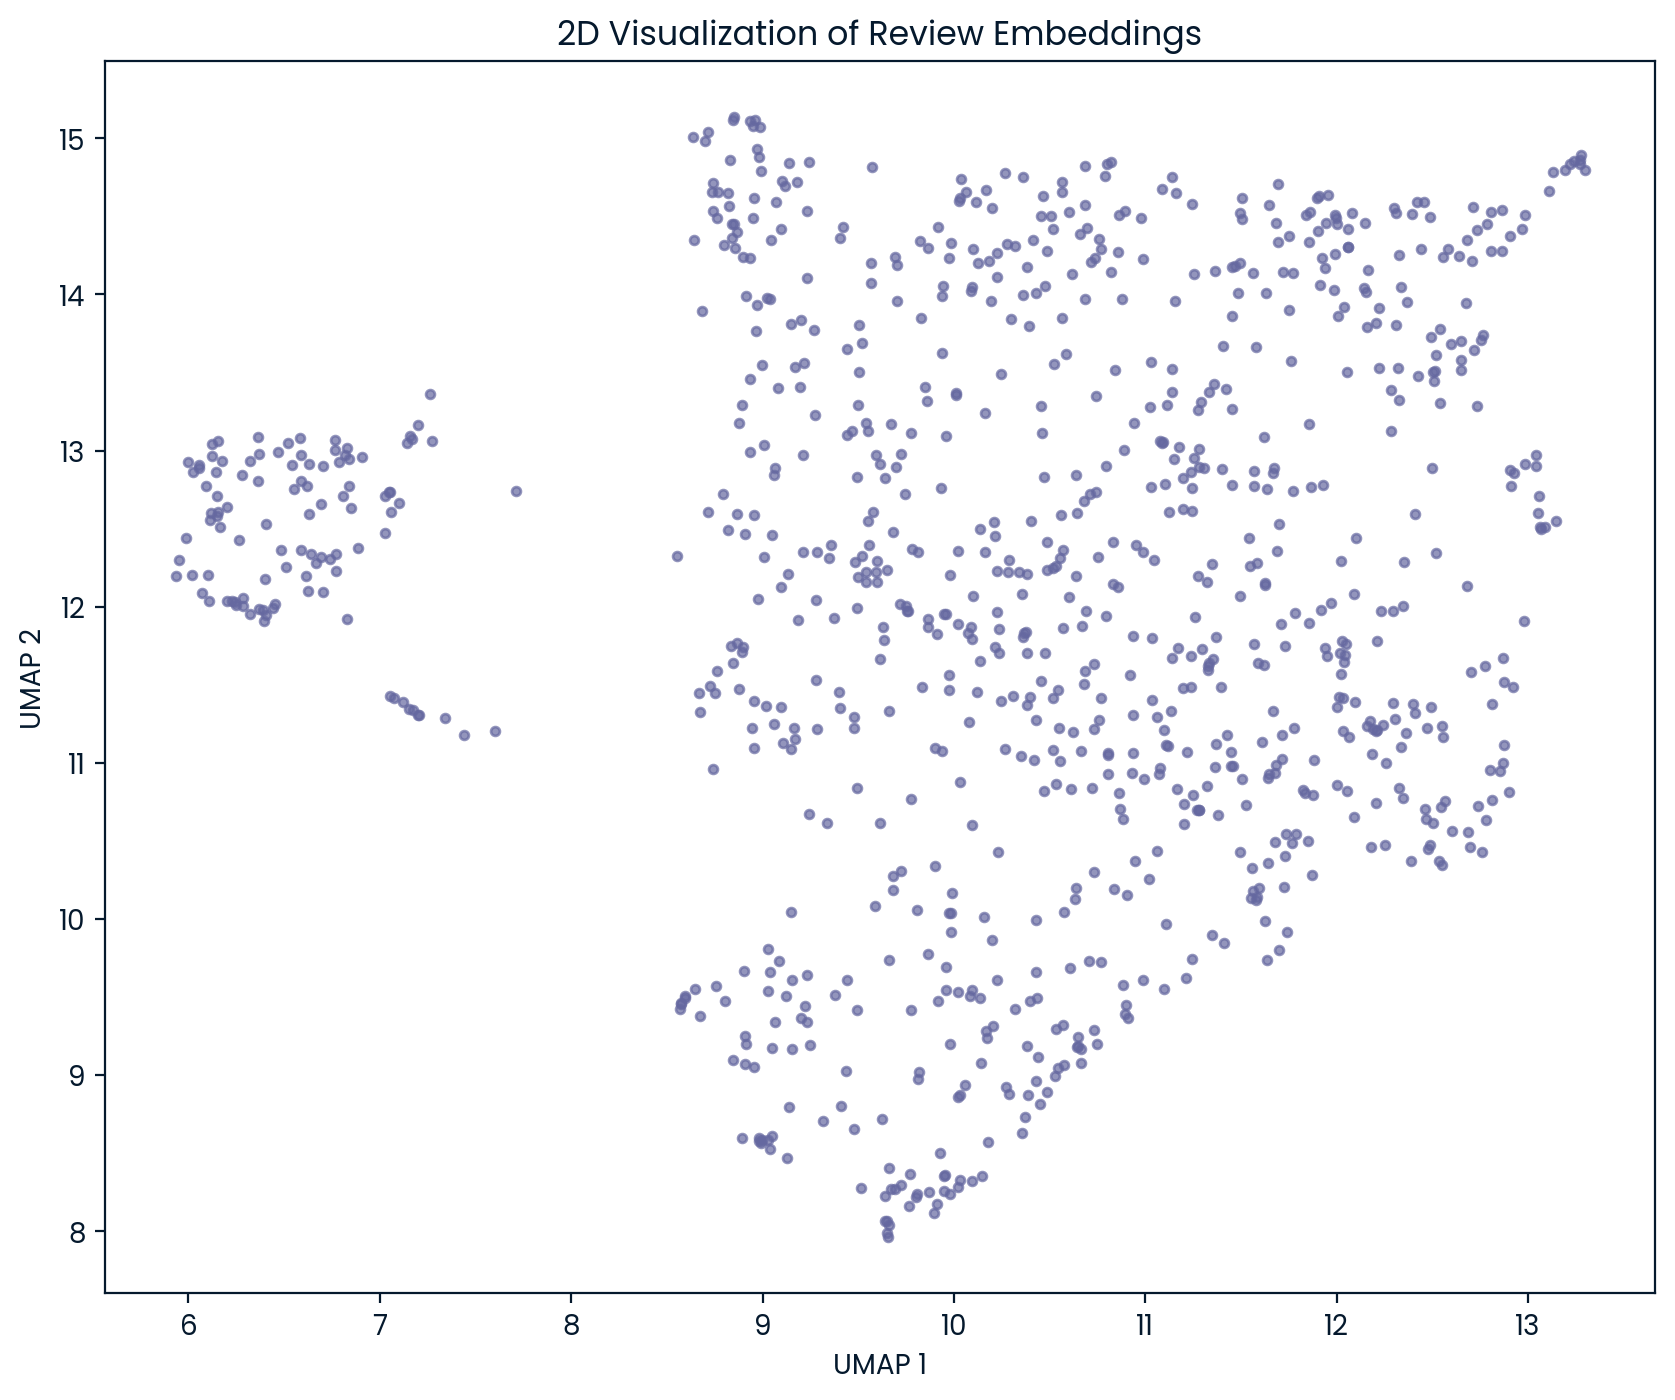

In [29]:

import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce to 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.7)
plt.title("2D Visualization of Review Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



In [30]:


categories = ['quality', 'fit', 'style', 'comfort']
categorized_reviews = {}

for category in categories:
    matches = valid_reviews[valid_reviews['Review Text'].str.contains(category, case=False)]
    categorized_reviews[category] = matches['Review Text'].head(3).tolist()  # Top 3 examples

categorized_reviews  # View grouped review samples


{'quality': ['More and more i find myself reliant on the reviews written by savvy shoppers before me and for the most past, they are right on in their estimation of the product. in the case of this dress-if it had not been for the reveiws-i doubt i would have even tried this. the dress is beautifully made, lined and reminiscent of the old retailer quality. it is lined in the solid periwinkle-colored fabric that matches the outer fabric print. tts and very form-fitting. falls just above the knee and does not rid',
  'This is a nice choice for holiday gatherings. i like that the length grazes the knee so it is conservative enough for office related gatherings. the size small fit me well - i am usually a size 2/4 with a small bust. in my opinion it runs small and those with larger busts will definitely have to size up (but then perhaps the waist will be too big). the problem with this dress is the quality. the fabrics are terrible. the delicate netting type fabric on the top layer of skir

In [31]:

from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews(input_text, texts, embeddings, top_k=3):
    input_embed = client.embeddings.create(
        model="text-embedding-3-small",
        input=[input_text]
    ).data[0].embedding

    similarities = cosine_similarity([input_embed], embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [texts[i] for i in top_indices]

# Apply it to the first review
input_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(input_review, texts, embeddings, top_k=3)
print(most_similar_reviews)

['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']
